# Computer Vision - MNIST
This notebook shows an approach to a *Supervised Learning - Multiclass Classification* task within the field of *Computer Vision*. More information about the datasets used in this notebook can be found below.

## MNIST
The MNIST dataset contains 70,000 small images of labeled handwritten digits, from *0 - 9*. This problem is often called as the "Hello World" of *Machine Learning* because anyone who learns Machine Learning tackles this problem at any time.  

Further information about the dataset can be found in the following webpages:  
[MNIST - Yann LeCun](http://yann.lecun.com/exdb/mnist/)  
[MNIST 784 - OpenML](https://www.openml.org/d/554)  
[MNIST - Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/mnist)

## Libraries & Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Modelling
import tensorflow as tf
from tensorflow import keras

#Dimensionality Reduction
from sklearn.decomposition import PCA

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## User Defined Functions

In [2]:
def plot_images(images_data,labels_data):
    fig, axes = plt.subplots(1, 8,figsize=(14,2))
    images_and_labels = list(zip(images_data[:8], labels_data[:8]))
    for ax, (image, label) in zip(axes, images_and_labels):
        image = image.reshape(28,28)
        ax.set_axis_off()
        ax.imshow(image, cmap = 'binary')
        ax.set_title(f'Label: {label}')

In [3]:
class accuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.998):
            print("\nReached 99.8% accuracy so cancelling training!\n")
            self.model.stop_training = True

## MNIST
The classification task will be tackled using *Convolutional Neural Networks - CNN* and will use two different datasets:
- Uncompressed Images
- Compressed Images using PCA

Each approach listed above has advantages &amp; disadvantages, that will be explained further in the *Error Analysis* section.

### Data Loading
Keras provides the Datasets API which allows the user to fetch open-sourced datasets, such as MNIST and Fashion MNIST. Firstly, we will use it to load the MNIST dataset. The MNIST contains:
- *Images* that corresponds to *70,000 examples* of *28x28* and is denoted as `X`.
- *Labels* that corresponds to a column vector which contains the *70,000* corresponding labels and is denoted as `y`.


\begin{equation*}
X = 
\begin{bmatrix}
x_{0,0} & \cdots & x_{0,27}\\
\vdots & \vdots & \vdots\\
x_{27,0} & \cdots & x_{27,27}\\
\end{bmatrix}_{70000\times 28 \times 28}
\quad
\quad
y = 
\begin{bmatrix}
y_{0,0}\\
\vdots\\
\vdots\\
\vdots\\
\vdots\\
\vdots\\
y_{69999,0}\\
\end{bmatrix}_{7000\times 1}
\end{equation*}

The Keras Datasets API splits the data into `training` &amp; `test` examples. It assigns *60,000* examples for `training` and *10,000* examples for `test`.

In [4]:
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

Let's check the type of the pixels in images and labels.

In [5]:
print(f'Pixels Training images type: {type(training_images[0][0][0])}')
print(f'Training labels type: {type(training_labels[0])}')
print(f'Pixels Test images type: {type(test_images[0][0][0])}')
print(f'Test labels type: {type(test_labels[0])}')

Pixels Training images type: <class 'numpy.uint8'>
Training labels type: <class 'numpy.uint8'>
Pixels Test images type: <class 'numpy.uint8'>
Test labels type: <class 'numpy.uint8'>


The pixels in images are *int8*, they will casted to *float32*.

In [6]:
training_images, test_images = training_images.astype('float32'), test_images.astype('float32')

print(f'Pixels Training images type: {type(training_images[0][0][0])}')
print(f'Pixels Test images type: {type(test_images[0][0][0])}')

Pixels Training images type: <class 'numpy.float32'>
Pixels Test images type: <class 'numpy.float32'>


The pixels will be rescaled, it will be a value between [0-1], this will improve the training process, because it reduces training time.

In [7]:
training_images, test_images = training_images / 255.0, test_images / 255.0

Let's check their dimensions.

In [8]:
print(f'Training images shape: {training_images.shape}')
print(f'Training labels shape: {training_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


The `labels` variables correspond to a *rank-1 array*, that is *(70000, )* in total. Also the `images` should be reshaped to *(70000,28,28,1)* in order to specify that there is only one color channel.

In [9]:
training_images = training_images.reshape(60000,28,28,1)
test_images = test_images.reshape(10000,28,28,1)

Some examples of the images are shown below.

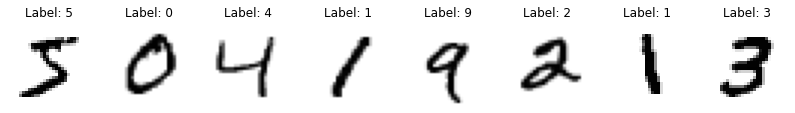

In [10]:
plot_images(training_images,training_labels)

The balance of different classes in the `target` variable will be checked as follows.

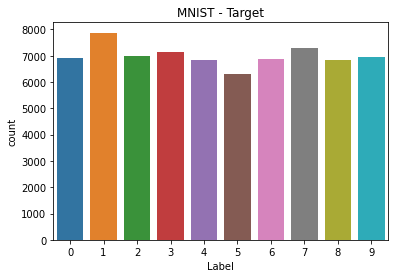

In [11]:
sns.countplot(np.concatenate((training_labels, test_labels), axis=0))
plt.title('MNIST - Target')
plt.xlabel('Label')
plt.show()

The dataset will be split into *Train &amp; Validation sets*, the *Validation set* will correspond to the *10%* of the total examples.

In [12]:
val_images = training_images[50000:]
val_labels = training_labels[50000:]

training_images = training_images[:50000]
training_labels = training_labels[:50000]

Let's check the shapes after split.

In [13]:
print(f'Training images shape: {training_images.shape}')
print(f'Training labels shape: {training_labels.shape}')
print(f'Validation images shape: {val_images.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Training images shape: (50000, 28, 28, 1)
Training labels shape: (50000,)
Validation images shape: (10000, 28, 28, 1)
Validation labels shape: (10000,)
Test images shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


The pixels in images correspond to a number between *[0 - 255]*, then the pixels will be rescaled as follows:

### Modelling

This phase will follow two approaches, both using the same *Convolutional Neural Network architecture*:
- Uncompressed images.
- Compressed images using PCA.

The architecture of the current Convolutional layer is shown below:

![CNN](../assets/CNN.svg)

The *accuracy* is the metric used to evaluate the performance of the model, the accuracy is defined as follows:

\begin{equation*}
accuracy\; =\; \dfrac{Number\; of\; correct\; predictions}{Total\; number\; of\; predictions}
\end{equation*}


#### Uncompressed Images
This approach will use rescaled images without any compression for *training*, *validation* &amp; *test* steps.

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')])

The method *compile()* allows us to define the optimizer, the loss function, metrics, and other parameters if necessary.

In [15]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

The method *summary()* provides an information about the parameters of each layer and the shape of their outputs.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Let's use the 
```python
class accuracyCallback()
```
to create a callback which will stop trainining the model once the *accuracy* reaches *99.8%*, which is quite high but the overfiting will be checked in the **Error Analysis** section.

In [17]:
accCallback = accuracyCallback()

The *fit()* method will train the model and the history of this step will be stored in the `history` variable in order to save the information to carry out the **Error Analysis** later. The model will be trained in *20 epochs*, but we expect to reach *99.8% accuracy* before the 15<sup>th</sup> epoch.

In [18]:
history_u = model.fit(training_images, training_labels,
                      validation_data = (val_images, val_labels),
                      callbacks = [accCallback],epochs = 20, verbose = 2)

Epoch 1/20
1563/1563 - 5s - loss: 0.1346 - accuracy: 0.9582 - val_loss: 0.0553 - val_accuracy: 0.9842
Epoch 2/20
1563/1563 - 5s - loss: 0.0457 - accuracy: 0.9858 - val_loss: 0.0351 - val_accuracy: 0.9898
Epoch 3/20
1563/1563 - 5s - loss: 0.0297 - accuracy: 0.9903 - val_loss: 0.0416 - val_accuracy: 0.9875
Epoch 4/20
1563/1563 - 5s - loss: 0.0214 - accuracy: 0.9932 - val_loss: 0.0387 - val_accuracy: 0.9898
Epoch 5/20
1563/1563 - 5s - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.0459 - val_accuracy: 0.9885
Epoch 6/20
1563/1563 - 5s - loss: 0.0130 - accuracy: 0.9957 - val_loss: 0.0385 - val_accuracy: 0.9905
Epoch 7/20
1563/1563 - 5s - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.0462 - val_accuracy: 0.9879
Epoch 8/20
1563/1563 - 5s - loss: 0.0076 - accuracy: 0.9972 - val_loss: 0.0528 - val_accuracy: 0.9890
Epoch 9/20
1563/1563 - 5s - loss: 0.0075 - accuracy: 0.9975 - val_loss: 0.0453 - val_accuracy: 0.9913
Epoch 10/20

Reached 99.8% accuracy so cancelling training!

1563/1563 - 5s - loss

The model reached the 99.8% accuracy in less than 15 epoch and now let's check it's performance over the test set.

In [19]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0398 - accuracy: 0.9911


[0.039839547127485275, 0.991100013256073]

99.1% test set accuracy, with this result we can tell that there was no overfiting.

#### Compressed images using PCA
The Principal Component Analysis allows us to compress the images. Initially the images consist on 784 pixels, we will use the *explained variance* to identify the numbers of components which can be kept.

To start this analysis let's perform the analysis over all the images, then the training set and validation set will be concatenated and reshaped in order to carry out this analysis.

In [20]:
training_images = np.concatenate((training_images, val_images), axis = 0)
training_labels = np.concatenate((training_labels, val_labels), axis = 0)

training_images = training_images.reshape(60000,784)

The Principal Component Analysis starts keeping all the components, that are 784 pixels.

In [21]:
pca = PCA()

The *fit()* method will perform the underlying steps of Principal Component Analysis over all the images.

In [22]:
pca.fit(training_images)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The explained variance ratio will be obtained by component and the *cumulative sum* of them in order to check graphically the number of components which can be kept.

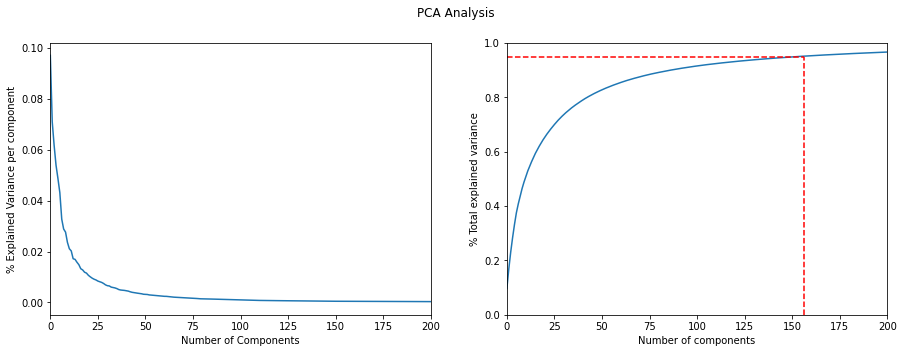

In [23]:
expl_var_comp = pca.explained_variance_ratio_
expl_var = pca.explained_variance_ratio_.cumsum()

fig,ax = plt.subplots(1, 2, sharex = True, sharey = False, figsize = (15,5))
plt.ylim(0, 1)
plt.xlim(0, 200)
plt.suptitle('PCA Analysis')

ax[0].plot(expl_var_comp)
ax[0].set_ylabel('% Explained Variance per component')
ax[0].set_xlabel('Number of Components')

ax[1].set_ylabel('% Total explained variance')
ax[1].set_xlabel('Number of components')
ax[1].plot(expl_var)
ax[1].plot([0, 156], [.95, .95],'r--')
ax[1].plot([156,156], [0, .95], 'r--')

plt.show()

If we take between [150 - 160] components they will keep the 95% of the total variance. 

We can explicity tell the PCA to keep the 95% of the variance as follows.

In [24]:
pca = PCA(0.95)

The images will be fit and transformed in order to keep the new components which are the output of the Principal Component Analysis.

In [25]:
training_images = pca.fit_transform(training_images)

Let's check the shape of the output.

In [26]:
training_images.shape

(60000, 154)

The results correspond to the 60,000 examples and 154 pixels were kept.

The training images will be reshaped to specify that there is only one channel.

In [27]:
training_images = training_images.reshape(60000,154,1)

The data will be split into *training* and *validation* sets.

In [28]:
val_images = training_images[50000:]
val_labels = training_labels[50000:]

training_images = training_images[:50000]
training_labels = training_labels[:50000]

We will use the same architecture used previously but changing the first convolutions to perform it over a 1D tensor.

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, (3), activation = 'relu', input_shape = (154,1)),
    tf.keras.layers.MaxPooling1D(2,2),
    tf.keras.layers.Conv1D(64, (3), activation = 'relu'),
    tf.keras.layers.MaxPooling1D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')])

The model willbe compiled as follows.

In [30]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

The summary of the model can be shown as follows.

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 152, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 76, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 74, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2368)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               303232    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

The history of the training will be stored in the `history` variable in order to save the information to carry out the **Error Analysis** later. The model will be trained in *30 epochs*, but we expect to reach *99.8% accuracy* before the 25<sup>th</sup> epoch.

In [32]:
history_c = model.fit(training_images, training_labels,
                      callbacks = [accCallback], epochs = 20,
                      validation_data = (val_images, val_labels), verbose = 2)

Epoch 1/20
1563/1563 - 5s - loss: 0.3620 - accuracy: 0.8887 - val_loss: 0.1825 - val_accuracy: 0.9469
Epoch 2/20
1563/1563 - 5s - loss: 0.1493 - accuracy: 0.9544 - val_loss: 0.1436 - val_accuracy: 0.9551
Epoch 3/20
1563/1563 - 5s - loss: 0.1022 - accuracy: 0.9673 - val_loss: 0.1446 - val_accuracy: 0.9584
Epoch 4/20
1563/1563 - 5s - loss: 0.0682 - accuracy: 0.9775 - val_loss: 0.1339 - val_accuracy: 0.9596
Epoch 5/20
1563/1563 - 5s - loss: 0.0472 - accuracy: 0.9840 - val_loss: 0.1335 - val_accuracy: 0.9637
Epoch 6/20
1563/1563 - 5s - loss: 0.0333 - accuracy: 0.9888 - val_loss: 0.1551 - val_accuracy: 0.9620
Epoch 7/20
1563/1563 - 5s - loss: 0.0262 - accuracy: 0.9910 - val_loss: 0.1623 - val_accuracy: 0.9621
Epoch 8/20
1563/1563 - 5s - loss: 0.0227 - accuracy: 0.9922 - val_loss: 0.1677 - val_accuracy: 0.9621
Epoch 9/20
1563/1563 - 5s - loss: 0.0187 - accuracy: 0.9933 - val_loss: 0.1987 - val_accuracy: 0.9620
Epoch 10/20
1563/1563 - 5s - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.1917 - 

### Error Analysis

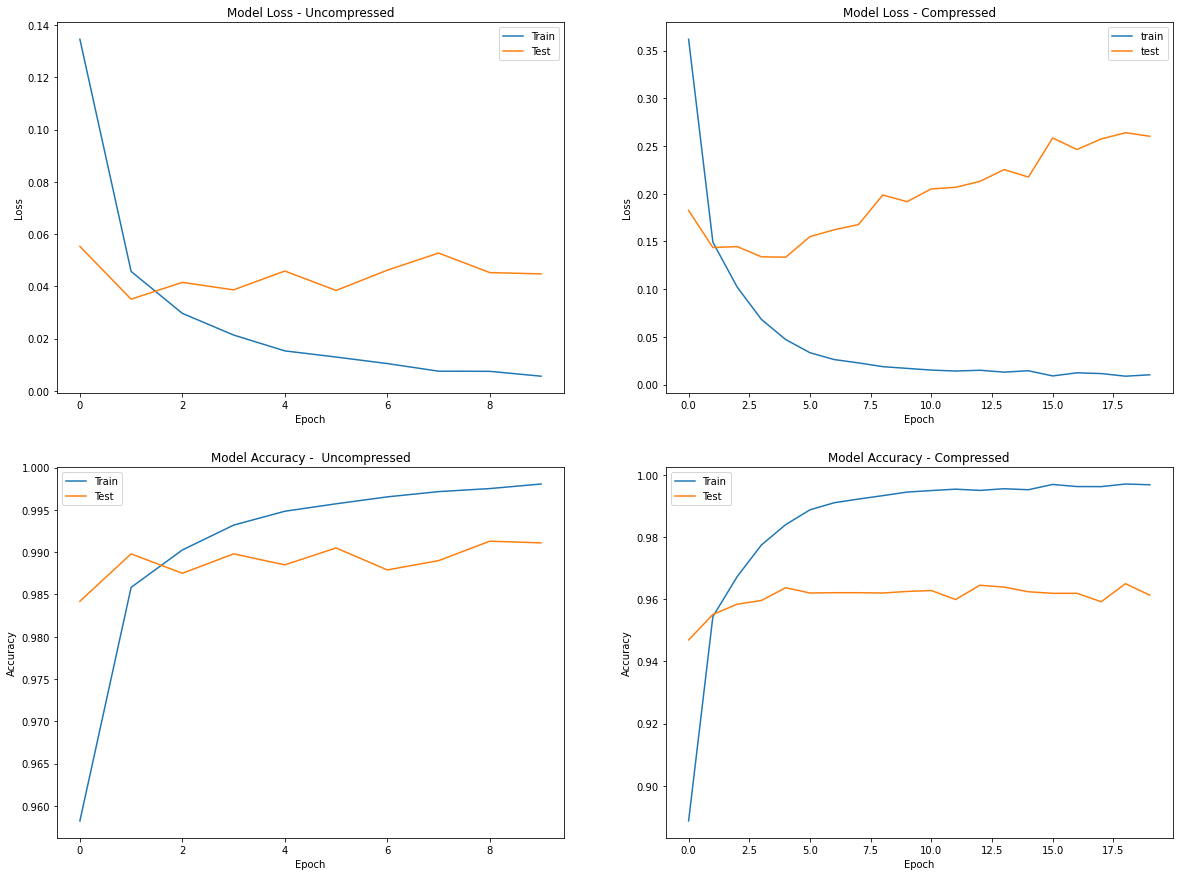

In [33]:
fig, ax = plt.subplots(2, 2, figsize = (20, 15))

ax[0,0].plot(history_u.history['loss'])
ax[0,0].plot(history_u.history['val_loss'])
ax[0,0].set_title('Model Loss - Uncompressed')
ax[0,0].legend(['Train', 'Test'], loc = 'best')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Epoch')

ax[1,0].plot(history_u.history['accuracy'])
ax[1,0].plot(history_u.history['val_accuracy'])
ax[1,0].set_title('Model Accuracy -  Uncompressed')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(['Train', 'Test'], loc = 'best')

ax[0,1].plot(history_c.history['loss'])
ax[0,1].plot(history_c.history['val_loss'])
ax[0,1].set_title('Model Loss - Compressed')
ax[0,1].legend(['train', 'test'], loc = 'best')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_xlabel('Epoch')

ax[1,1].plot(history_c.history['accuracy'])
ax[1,1].plot(history_c.history['val_accuracy'])
ax[1,1].set_title('Model Accuracy - Compressed')
ax[1,1].set_ylabel('Accuracy')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(['Train', 'Test'], loc = 'best')

plt.show()